In [6]:
from brian2 import *
import brian2.numpy_ as np
prefs.codegen.target = 'numpy'

start_scope()
#Implementing the independent CaN current.

duration = 100*ms
#Parameters
C = 1*ufarad
V0 = -65*mV
gCaNmax = 0.001*siemens
temp = 34
Cai = 50 * nmole
Cao = 2 * mmole
q10CaN = 5
a0mCaN = 0.03/ms
zetamCaN = 2/mV
vhalfmCaN = -14*mV
gmmCaN = 0.1
f = ((25/293.15)*(temp + 273.15))*mV/2
kiCaN = 1*nmole
h2CaN = kiCaN/(kiCaN+Cai)

@check_units(z=1, result=1)    
def efun(z):
    if (np.absolute(z) < 0.0001): 
        return 1 - z/2
    else:
        return z/(exp(z) - 1)
    
@check_units(V=volt, result=1)
def nu(V):
    return V / f


@check_units(V=volt, result=volt)
def ghk(V):
    return -f * (1 - (Cai / Cao) * exp(nu(V))) * efun(nu(V))

eqs = Equations('''
                    dV/dt = (ICaN + I)/C : volt
                    ICaN = gCaN*ghk(V) : amp (constant over dt)
                    gCaN = gCaNmax*mCaN*mCaN*hCaN*h2CaN : siemens
                    dmCaN/dt = (infmCaN - mCaN)/taumCaN : 1
                    dhCaN/dt = (infhCaN - hCaN)/tauhCaN : 1
                    infmCaN = alpmCaN*(1/alpmCaN+betmCaN) : 1
                    infhCaN = alphCaN*(1/alphCaN+bethCaN) : 1
                    taumCaN = betmtCaN/(qtCaN*a0mCaN*(1+alpmtCaN)) : second
                    tauhCaN = (1*ms/(alphCaN+bethCaN))/qtCaN : second
                    alpmCaN = 0.1967*(mV**-1)*(-V+19.88*mV)/(exp((-V+19.88*mV)/(10.0*mV))-1) : 1
                    alphCaN = 0.00016*exp(-V/(48.4*mV)) : 1
                    alpmtCaN = exp(0.0378*zetamCaN*(V-vhalfmCaN)) : 1 
                    betmCaN = 0.046*exp(-V/(20.73*mV)) : 1
                    bethCaN = 1/(exp((-V+39*mV)/(10*mV))+1) : 1
                    betmtCaN = exp(0.0378*zetamCaN*gmmCaN*(V-vhalfmCaN)) : 1
                    qtCaN = q10CaN ** ((temp - 25) / 10) : 1
                    I : amp
                    ''')

group = NeuronGroup(1, eqs, threshold='V > -40*mV', refractory='V > -40*mV', method='rk2')
M = StateMonitor(group, variables=True, record=True)

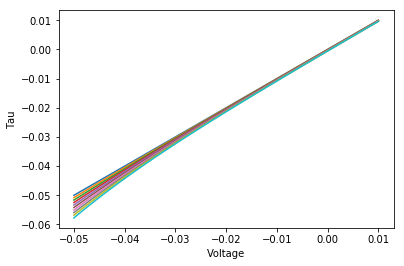

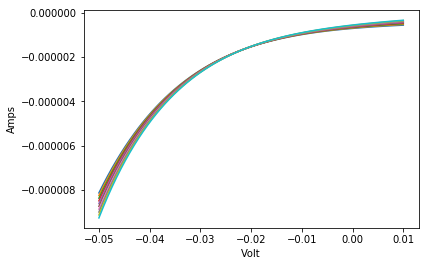

In [7]:
store()
# Plot tau and the channel current for different voltages
voltages = np.linspace(-50, 10, 70) * mV
vs = []
Is = []
for volt in voltages:
    # Restore the original state of the network
    restore()
    group.V = volt
    alpm0 = 0.1967*(mV**-1)*(-volt+19.88*mV)/(exp((-volt+19.88*mV)/(10*mV))-1)
    betm0 = 0.046*exp(65/20.73)
    group.mCaN = alpm0*(1/alpm0+betm0)
    group.hCaN = 0.00016*exp(-volt/(48.4*mV))*(1/0.00016*exp(-volt/(48.4*mV))+1/(exp((-volt+39*mV)/(10*mV))+1))
    # Run it with the new value of tau
    run(1 * ms)
    vs.append(M.V[0])
    Is.append(M.ICaN[0])

figure(1)
plot(voltages, vs)
xlabel('Voltage')
ylabel('Tau');

figure(2)
plot(voltages, Is)
xlabel('Volt')
ylabel('Amps');
show()